In [1]:
# --- Before your go ----
# 1. Rename Assignment-02-###.ipynb where ### is your student ID.
# 2. The deadline of Assignment-02 is 23:59pm, 04-18-2023


In [2]:
# In this assignment, you will use word embeddings to explore our Wikipedia dataset.


In [1]:
# Task 1 --- Train word embeddings using SGNS ---
# Use our enwiki-train.json as training data. 
# You can use the Gensim tool (https://radimrehurek.com/gensim/models/word2vec.html). 
# But it is recommended to implement by yourself.
# You should explain how hyper-parameters such as dimensionality of embeddings, window size, 
# the parameter of negative sampling strategy, and initial learning rate have been chosen.

# Your code

import re
import nltk

train_path="enwiki-train.json"
test_path="enwiki-test.json"  

def process_dataset(json_path):
    out=[]
    with open(json_path) as f:
        json_list=f.readlines()
    for item in json_list:
        dict=eval(item)
        for sent in nltk.sent_tokenize(dict["text"]):
            out.append([c.lower() for c in nltk.word_tokenize(sent) if not bool(re.match('^[!"#$%&\'()*+“”–,-.’/:;<=>?@[\\]^_`{|}~ ]+$', c))])
    return out

sen_list=process_dataset(train_path)

# save it
with open('sen.txt', 'w') as f:
    for item in sen_list:
        f.write("%s\n" % item)

In [9]:
from nltk.probability import FreqDist
def build_vocab(sent_list):
    word_list=[]
    for i in sent_list:  
        word_list+=i
    freq=FreqDist(word_list)
    return freq

freq_dist=build_vocab(sen_list)

In [57]:
# gensim version
from gensim.models import Word2Vec

model = Word2Vec(sentences=sen_list, vector_size=100, window=4, min_count=1, workers=16, sg=1, hs=0, negative=10, ns_exponent=0.75, alpha=0.025)

In [30]:
# my word2vec
import numpy as np
from tqdm import tqdm
from nltk.probability import FreqDist
from livelossplot import PlotLosses

class my_Word2Vec:
    def __init__(self, sentences, vector_size=100, window=3, negative=5, ns_exponent=0.75, alpha=0.025):
        self.sentences = sentences
        self.vector_size = vector_size
        self.window = window
        self.negative = negative
        self.alpha = alpha
        self.ns_exponent=ns_exponent
        
        self.build_vocab()
        
        self.W1 = np.random.uniform(-0.5, 0.5, (self.vocab_size, self.vector_size))/self.vector_size
        # self.W2 = np.random.uniform(-0.5, 0.5, (self.vocab_size, self.vector_size))/self.vector_size
        self.W2=np.zeros([self.vocab_size, self.vector_size])
        self.wc=0

    def build_vocab(self):
        word_list=[]
        for i in self.sentences:  
            word_list+=i
        self.word_cnt=len(word_list)
        freq=FreqDist(word_list)
        self.freq=freq
        self.vocab=list(freq.keys())
        freq_values = np.array(list(freq.values()))
        freq_values=freq_values/sum(freq_values)
        freq_values=np.power(freq_values, self.ns_exponent)
        self.vocab_p=freq_values/sum(freq_values)
        self.vocab_size=len(self.vocab)
        self.word2idx = {w: i for i, w in enumerate(self.vocab)}
        self.idx2word = {i: w for w, i in self.word2idx.items()}

    def train(self, epochs):
        plotlosses = PlotLosses()
        dataset=[]
        loss=[]
        for sentence in tqdm(self.sentences):
            for i, center_word in enumerate(sentence):
                context_words = sentence[max(0, i - self.window): i] + sentence[i + 1: min(len(sentence), i + self.window + 1)]
                dataset.append([center_word, context_words, len(sentence)])
                # for c_w in context_words:
                #     dataset.append([center_word, [c_w], len(sentence)])
        for epoch in range(epochs):
            a=np.arange(0,len(dataset))
            np.random.shuffle(a)
            for i in tqdm(a):
                center_word, context_words, len_sen=dataset[i]
                loss.append(self.train_step(center_word, context_words, len_sen)) 
                if(len(loss)==2000):
                    plotlosses.update({'loss':np.mean(loss)})
                    plotlosses.send()
                    # print(np.mean(loss))
                    loss=[] 
            self.save_weight()  
            print(f"Epoch: {epoch} Finish!")
            
    def train_step(self, center_word, context_words ,sen_len):
        self.wc+=1
        w_idx=self.word2idx[center_word]
        w = self.W1[w_idx]

        c_pos_idx=[]
        for context_word in context_words:
            c_pos_idx.append(self.word2idx[context_word])
        c_pos = self.W2[c_pos_idx]

        c_neg_idx = np.random.choice(self.vocab_size, size=self.negative*len(context_words), p=self.vocab_p, replace=False)
        c_neg=self.W2[c_neg_idx]

        loss=0
        grad_w=0
        lr=self.alpha*(1.-self.wc/(sen_len*self.vocab_size+1))
        # print(lr)
        if(lr < 0.0001*self.alpha):
            lr = 0.0001*self.alpha

        # c_pos
        c_pos_dot_w=self.sigmoid(c_pos.dot(w))
        loss-=np.sum(np.log(c_pos_dot_w))
        grad_c_pos=(c_pos_dot_w-1).reshape(-1,1)*w
        grad_w+=np.matmul((c_pos_dot_w-1).reshape(1,-1),c_pos)
        self.W2[c_pos_idx]-=lr*grad_c_pos

        # c_neg
        c_neg_dot_w=self.sigmoid(c_neg.dot(w))
        loss-=np.sum(np.log(1-c_neg_dot_w))
        grad_c_neg=(c_neg_dot_w).reshape(-1,1)*w
        grad_w+=np.matmul((c_neg_dot_w).reshape(1,-1),c_neg)
        self.W2[c_neg_idx]-=lr*grad_c_neg
        
        # w
        self.W1[w_idx]-=lr*grad_w.reshape(self.vector_size)

        return loss
        
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def get_embedding(self, word):
        if word in self.vocab:
            return (self.W1[self.word2idx[word]]+self.W2[self.word2idx[word]])/2
        else:
            return None
    def save_weight(self):
        np.save('W1.npy',self.W1)
        np.save('W2.npy',self.W2)
        np.save('word2idx.npy', self.word2idx)
        np.save('vocab.npy',self.vocab)
    
    def load_weight(self):
        self.W1=np.load('W1.npy')
        self.W2=np.load('W2.npy')
        self.word2idx = np.load('word2idx.npy',allow_pickle=True).item()
        self.vocab = np.load('vocab.npy',allow_pickle=True).tolist()

    def get_sen_emb(self,sent,mode=1):
        id=[]
        for word in sent:
            id.append(self.word2idx[word])
        if(mode==1):
            return np.mean((self.W1[id]+self.W2[id])/2,axis=0)
        if(mode==2):
            return np.mean(self.W1[id],axis=0)
        if(mode==3):
            return np.mean(self.W2[id],axis=0)


In [2]:
# load processed dataset
with open('sen.txt', 'r') as f:
    sen_list = [eval(line.strip()) for line in f.readlines()]

In [47]:
my_model=my_Word2Vec(sentences=sen_list, vector_size=100, window=4, negative=10, ns_exponent=0.75, alpha=0.025)

# dimensionality of embeddings
# vector_size=100  To save time, we choose a relatively lower size with good performance according to experiments in GloVe https://nlp.stanford.edu/pubs/glove.pdf

# window size
# window=4  To save time, we choose a relatively lower size with good performance according to experiments in GloVe https://nlp.stanford.edu/pubs/glove.pdf

# the parameter of negative sampling strategy
# negative=10  Choice of k=5 ~ 20 for small data sets (Mikolov et al., 2013)
# ns_exponent=0.75 0.75 yielded the best result in the original paper

# initial learning rate
# alpha=0.025  use a low learning rate to make training process stable and use learning rate decay to make convergence better. 𝜂_𝑡=𝜂_0⋅(1−𝑤𝑐/(𝑇^′⋅|𝑉|+1)), where 𝑤𝑐 number of training words processed

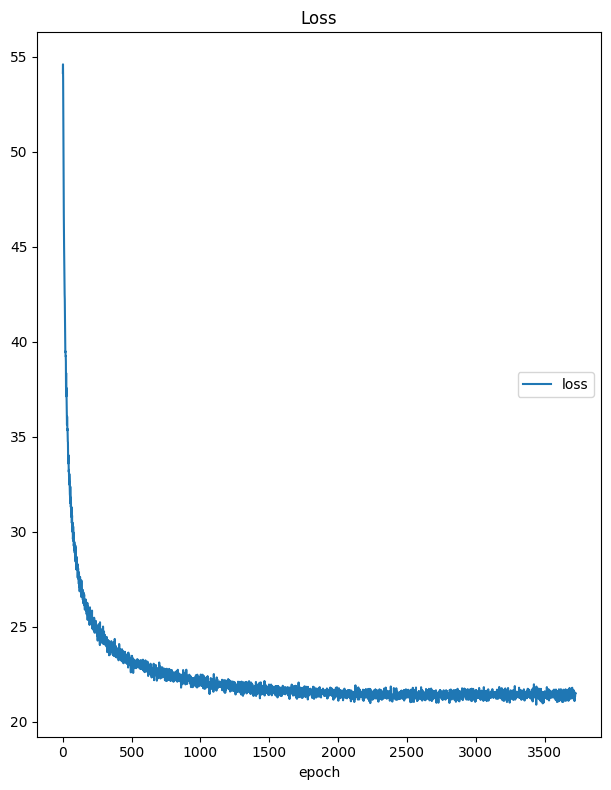

100%|█████████▉| 7452081/7453490 [5:12:28<00:04, 322.13it/s]

Loss
	loss             	 (min:   20.908, max:   54.608, cur:   21.510)


100%|██████████| 7453490/7453490 [5:12:32<00:00, 397.47it/s]


Epoch: 0 Finish!


In [48]:
my_model.train(1)

In [6]:
# Task 2 --- Find similar/dissimilar word pairs ---
# Randomly generate 100, 1000, and 10000-word pairs from the vocabularies. 
# For each set, print 5 closest word pairs and 5 furthest word pairs 
# (you can use cosine-similarity to measure two words). Explain your findings.

# Your code

In [ ]:
my_model.load_weight()

In [66]:
word_list = list(freq_dist.keys())
freq_list = np.array(list(freq_dist.values()))
freq_list=freq_list/sum(freq_list)

def generate_word_pairs(num,freq=False):
    out=[]
    for i in range(num):
        if(freq):
            out.append(list(np.random.choice(word_list, size=2, replace=False, p=freq_list)))
        else:
            out.append(list(np.random.choice(word_list, size=2, replace=False)))
    return out

def cosine_similarity(a,b):
    a=np.array(a)
    b=np.array(b)
    return a.dot(b)/np.linalg.norm(a)/np.linalg.norm(b)

def find_similarity(word_pairs,gensim=1):
    tmp=[]
    print("-----------")
    print("gensim version" if gensim==1 else "my version")
    print("**************")
    for a,b in word_pairs:
        if(gensim):
            tmp.append(cosine_similarity(model.wv[a],model.wv[b]))
        else:
            tmp.append(cosine_similarity(my_model.get_embedding(a),my_model.get_embedding(b)))
    sorted_list = sorted(enumerate(tmp), key=lambda x: x[1], reverse=True)
    top_5_indices = [index for index, _ in sorted_list[:5]]
    least_5_indices = [index for index, _ in sorted_list[-1:-6:-1]]
    for i,index in enumerate(top_5_indices):
        print(f"Top{i+1}: Similarity:{tmp[index]:.3f} {word_pairs[index]} ")
    print("-----------")
    for i,index in enumerate(least_5_indices):
        print(f"Least{i+1}: Similarity:{tmp[index]:.3f} {word_pairs[index]} ")

In [79]:
num_pairs=10
pair1=generate_word_pairs(num_pairs,freq=True)
print("Number of pairs:",num_pairs)
find_similarity(pair1,gensim=0)
find_similarity(pair1,gensim=1)

Number of pairs: 10
-----------
my version
**************
Top1: Similarity:0.696 ['24', '1981'] 
Top2: Similarity:0.662 ['reputation', 'hopper'] 
Top3: Similarity:0.572 ["o'malley", 'he'] 
Top4: Similarity:0.558 ['his', 'the'] 
Top5: Similarity:0.549 ['was', 'consensus'] 
-----------
Least1: Similarity:0.414 ['lines', 'commission'] 
Least2: Similarity:0.417 ['they', 'from'] 
Least3: Similarity:0.497 ['from', 'scenes'] 
Least4: Similarity:0.516 ['begin', 'behind'] 
Least5: Similarity:0.532 ['ambiguous', 'each'] 
-----------
gensim version
**************
Top1: Similarity:0.647 ["o'malley", 'he'] 
Top2: Similarity:0.537 ['24', '1981'] 
Top3: Similarity:0.515 ['reputation', 'hopper'] 
Top4: Similarity:0.497 ['his', 'the'] 
Top5: Similarity:0.433 ['ambiguous', 'each'] 
-----------
Least1: Similarity:0.244 ['from', 'scenes'] 
Least2: Similarity:0.281 ['lines', 'commission'] 
Least3: Similarity:0.396 ['begin', 'behind'] 
Least4: Similarity:0.407 ['was', 'consensus'] 
Least5: Similarity:0.409 

Comparing the results for only 10 word pairs, we can observe that both versions yield similar results, but with some differences in the order of similarity scores and word pairs.

In [82]:
num_pairs=100
pair1=generate_word_pairs(num_pairs,freq=True)
print("Number of pairs:",num_pairs)
find_similarity(pair1,gensim=0)
find_similarity(pair1,gensim=1)

Number of pairs: 100
-----------
my version
**************
Top1: Similarity:0.873 ['of', 'the'] 
Top2: Similarity:0.799 ['area', 'building'] 
Top3: Similarity:0.796 ['and', 'the'] 
Top4: Similarity:0.718 ['he', 'rostow'] 
Top5: Similarity:0.710 ['bad', 'still'] 
-----------
Least1: Similarity:-0.653 ['gar', 'that'] 
Least2: Similarity:-0.607 ['liess', 'bhutto'] 
Least3: Similarity:-0.598 ['magaoikkal', 'chamberlain'] 
Least4: Similarity:-0.549 ['32gbps', 'over'] 
Least5: Similarity:-0.508 ['from\\', 'version'] 
-----------
gensim version
**************
Top1: Similarity:0.810 ['of', 'the'] 
Top2: Similarity:0.788 ['and', 'the'] 
Top3: Similarity:0.741 ['the', 'a'] 
Top4: Similarity:0.695 ['area', 'building'] 
Top5: Similarity:0.647 ['the', 'this'] 
-----------
Least1: Similarity:0.139 ['british', 'dementia'] 
Least2: Similarity:0.172 ['earned', 'the'] 
Least3: Similarity:0.213 ['a', 'house'] 
Least4: Similarity:0.238 ['factors', 'fashion'] 
Least5: Similarity:0.242 ['broke', 'dish'] 


In [85]:
num_pairs=1000
pair1=generate_word_pairs(num_pairs,freq=True)
print("Number of pairs:",num_pairs)
find_similarity(pair1,gensim=0)
find_similarity(pair1,gensim=1)

Number of pairs: 1000
-----------
my version
**************
Top1: Similarity:0.873 ['the', 'of'] 
Top2: Similarity:0.873 ['the', 'of'] 
Top3: Similarity:0.873 ['the', 'of'] 
Top4: Similarity:0.873 ['of', 'the'] 
Top5: Similarity:0.873 ['of', 'the'] 
-----------
Least1: Similarity:-0.807 ['the', 'wambui'] 
Least2: Similarity:-0.805 ['saito', 'the'] 
Least3: Similarity:-0.800 ['the', 'aoyama'] 
Least4: Similarity:-0.786 ['seacoast', 'and'] 
Least5: Similarity:-0.785 ['fierce', 'little-seen'] 
-----------
gensim version
**************
Top1: Similarity:0.914 ['costello', 'nizhegorodsky'] 
Top2: Similarity:0.823 ['of', 'and'] 
Top3: Similarity:0.823 ['of', 'and'] 
Top4: Similarity:0.823 ['and', 'of'] 
Top5: Similarity:0.815 ['raid-z', 'purgatory'] 
-----------
Least1: Similarity:0.107 ['and', 'jerry'] 
Least2: Similarity:0.116 ['new', 'levels'] 
Least3: Similarity:0.121 ['and', 'friend'] 
Least4: Similarity:0.123 ['dutch', 'can'] 
Least5: Similarity:0.131 ['1994', 'such'] 


In [84]:
num_pairs=10000
pair1=generate_word_pairs(num_pairs,freq=True)
print("Number of pairs:",num_pairs)
find_similarity(pair1,gensim=0)
find_similarity(pair1,gensim=1)

Number of pairs: 10000
-----------
my version
**************
Top1: Similarity:0.962 ['fresh—as', 'caquets'] 
Top2: Similarity:0.960 ['disturbances', 'bladder'] 
Top3: Similarity:0.946 ['1940', '1908'] 
Top4: Similarity:0.934 ['sportsmen', 'succor'] 
Top5: Similarity:0.931 ['ccid', 'remaster'] 
-----------
Least1: Similarity:-0.868 ['champlin', 'exam'] 
Least2: Similarity:-0.863 ['campaign—he', 'gift'] 
Least3: Similarity:-0.850 ['bewley', 'practice'] 
Least4: Similarity:-0.843 ['the', "'shut"] 
Least5: Similarity:-0.836 ['the', 'wattis'] 
-----------
gensim version
**************
Top1: Similarity:0.963 ['czartoryski', 'colonialism-—was'] 
Top2: Similarity:0.961 ['glucofructans', 'ummah'] 
Top3: Similarity:0.945 ['bookstall', 'swans'] 
Top4: Similarity:0.937 ['fresh—as', 'caquets'] 
Top5: Similarity:0.936 ['sportsmen', 'succor'] 
-----------
Least1: Similarity:-0.031 ['life', '4851'] 
Least2: Similarity:0.024 ['receptor', 'his'] 
Least3: Similarity:0.030 ['of', 'david'] 
Least4: Similar

It can be seen from the result above that, with the incresing of number of the word pairs, the range of similarity value becomes wider. This matches our understanding, since increasing the number of word pairs will increase the probability of sampling more similar or less similar word pairs.

When the number of word pairs is small, the closest word pairs tend to consist of commonly used words with a strong syntactic relationship, while the least similar pairs are usually unrelated words with little or no semantic or syntactic relationship.

But when the number of word pairs is big, the most similar word pairs are not the similar word pairs that we commonly understand and have more rare words. This is beacause the similarity calculation in Word2vec is based on the co-occurrence relationships between words in context, rather than on their semantics or meanings. Word2vec believes that if two words appear in many similar contexts, then their similarity is higher. Therefore, if some uncommon words appear less frequently in the text, but their co-occurrence relationships with other words in some contexts are relatively obvious, then their similarity will be higher. Conversely, some common words may appear in many different contexts, and their co-occurrence relationships with other words may not be so obvious, so their similarity may be lower.

In [ ]:
# Task 3 --- Present a document as an embedding ---
# For each document, you have several choices to generate document embedding:
# 1. Use the average of embeddings of all words in each document.
# 2. Use the first paragraph’s words and take an average on these embeddings.
# 3. Use the doc2vec algorithm to present each document.
# Do the above for both training and testing dataset

# Your code

In [306]:
labels = ['Film','Book','Politician','Writer','Food','Actor','Animal','Software','Artist','Disease']
label_dict = {label: i for i, label in enumerate(labels)}
def id2label(id):
    return [labels[i] for i in id]

train_path="enwiki-train.json"
test_path="enwiki-test.json" 


In [201]:
# 1. Average of embeddings of all words in each document
def process_dataset_1(json_path):
    X=[]
    y=[]
    with open(json_path) as f:
        json_list=f.readlines()
    for item in tqdm(json_list):
        dict=eval(item)
        out=[]
        for sent in nltk.sent_tokenize(dict["text"]):
            out+=([c.lower() for c in nltk.word_tokenize(sent) if c.lower() in freq_dist])
        X.append(my_model.get_sen_emb(out,mode=1))
        y.append(label_dict[dict["label"]])
    return X,y
X_1,y_1=process_dataset_1(train_path)
X_test_1,y_test_1=process_dataset_1(test_path)

100%|██████████| 100/100 [00:03<00:00, 28.08it/s]


In [192]:
# 2. Average on the first paragraph’s words
def process_dataset_2(json_path):
    X=[]
    y=[]
    with open(json_path) as f:
        json_list=f.readlines()
    for item in tqdm(json_list):
        dict=eval(item)
        out=[]
        i=0
        while(len(out)==0):
            out+=[c.lower() for c in nltk.word_tokenize(dict["text"].split("\n")[i]) if c.lower() in freq_dist]
            i+=1
        X.append(my_model.get_sen_emb(out,mode=1))
        y.append(label_dict[dict["label"]])
    return X,y
X_2,y_2=process_dataset_2(train_path)
X_test_2,y_test_2=process_dataset_2(test_path)

100%|██████████| 100/100 [00:00<00:00, 1298.42it/s]


In [269]:
# 3. The doc2vec embedding
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
y_3=[]
y_test_3=[]
out=[]
out_2=[]
with open(train_path) as f:
    json_list_1=f.readlines()
for item in tqdm(json_list_1):
    dict=eval(item)
    y_3.append(label_dict[dict["label"]])
    out.append([c.lower() for c in nltk.word_tokenize(dict["text"]) if not bool(re.match('^[!"#$%&\'()*+“”–,-.’/:;<=>?@[\\]^_`{|}~ ]+$', c))])
with open(test_path) as f:
    json_list_2=f.readlines()
for item in tqdm(json_list_2):
    dict=eval(item)
    y_test_3.append(label_dict[dict["label"]])
    out_2.append([c.lower() for c in nltk.word_tokenize(dict["text"]) if not bool(re.match('^[!"#$%&\'()*+“”–,-.’/:;<=>?@[\\]^_`{|}~ ]+$', c))])
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(out)]
doc2vec_model=Doc2Vec(documents, vector_size=100, min_count=1, workers=16)
X_3=[doc2vec_model.infer_vector(v) for v in out]
X_test_3=[doc2vec_model.infer_vector(v) for v in out_2]

100%|██████████| 100/100 [00:02<00:00, 37.28it/s]


In [93]:
# Task 4 --- Build classifier to test docs ---
# Build softmax regression model to classifier testing documents based on 
# these training doc embeddings. Does it getting better than Naive Bayes'?
# (You have 3 models.)

# Your code

In my previous homework, the accuracy of Naive Bayes' is 0.81

In [354]:
# 1. Average of embeddings of all words in each document
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_1, y_1)
print("training accuracy:",clf.score(X_1, y_1))
print("test accuracy:",clf.score(X_test_1, y_test_1))

training accuracy: 0.907
test accuracy: 0.91


In [355]:
# 2. Average on the first paragraph’s words
clf = LogisticRegression(random_state=0).fit(X_2, y_2)
print("training accuracy:",clf.score(X_2, y_2))
print("test accuracy:",clf.score(X_test_2, y_test_2))

training accuracy: 0.913
test accuracy: 0.84


In [356]:
# 3. The doc2vec embedding
clf = LogisticRegression(random_state=0,max_iter=1000).fit(X_3, y_3)
print("training accuracy:",clf.score(X_3, y_3))
print("test accuracy:",clf.score(X_test_3, y_test_3))

training accuracy: 1.0
test accuracy: 0.94


All better than Naive Bayes. Average on the first paragraph’s words performs worst since this model doesn't make use of all the info in the doc. Doc2vec performs the best, as it may learn more inherent info about the doc than just averaging on embeddings of all words in each document.

In [ ]:
# Task 5 --- Use t-SNE to project doc vectors ---
# Use t-SNE to project training document embeddings into 2d and 
# plot them out for each of the above choices. 
# Each point should have a specific color (represent a particular cluster). 
# You may need to try different parameters of t-SNE. One can find more details about t-SNE in 
# this excellent article (https://distill.pub/2016/misread-tsne/ (Links to an external site.)).

# Your code

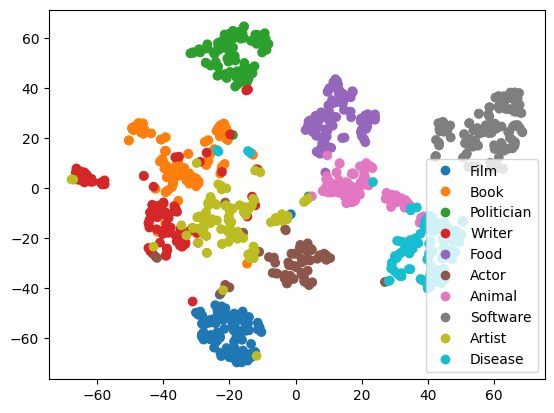

In [351]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# 1. Average of embeddings of all words in each document
X_1_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=9).fit_transform(np.array(X_1))
cmap = plt.cm.tab10
plt.scatter(X_1_embedded[:,0], X_1_embedded[:,1], c=y_2, cmap=cmap)
handles = [plt.plot([],[], marker="o", ls="", color=c)[0] for c in plt.cm.tab10(np.arange(10))]
labels = id2label(np.arange(10))
plt.legend(handles, labels, loc="lower right")
plt.show()

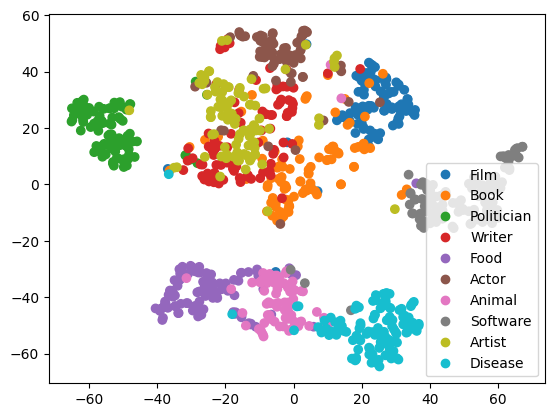

In [352]:
# 2. Average on the first paragraph’s words
X_2_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=9).fit_transform(np.array(X_2))
cmap = plt.cm.tab10
plt.scatter(X_2_embedded[:,0], X_2_embedded[:,1], c=y_2, cmap=cmap)
handles = [plt.plot([],[], marker="o", ls="", color=c)[0] for c in plt.cm.tab10(np.arange(10))]
labels = id2label(np.arange(10))
plt.legend(handles, labels, loc="lower right")
plt.show()

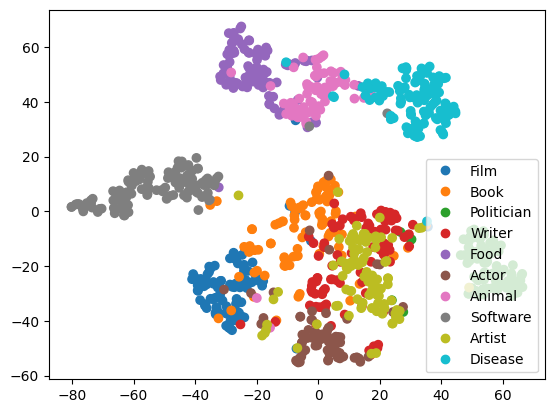

In [353]:
# 3. The doc2vec embedding
X_3_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=9).fit_transform(np.array(X_2))
cmap = plt.cm.tab10
plt.scatter(X_3_embedded[:,0], X_3_embedded[:,1], c=y_2, cmap=cmap)
handles = [plt.plot([],[], marker="o", ls="", color=c)[0] for c in plt.cm.tab10(np.arange(10))]
labels = id2label(np.arange(10))
plt.legend(handles, labels, loc="lower right")
plt.show()